# Prelim, Loading Data and Cleaning

In [2]:
import polars as pl

df = pl.read_csv("data/2024plays.csv")
print(df.head())
df = df.sort(
    by=[
        "gid",
        "date",
        "inning",
        "top_bot",
        "outs_pre",
    ]
)

shape: (5, 161)
┌──────────────┬────────┬────────┬─────────┬───┬────────┬──────────┬──────────┬──────┐
│ gid          ┆ event  ┆ inning ┆ top_bot ┆ … ┆ umprf  ┆ date     ┆ gametype ┆ pbp  │
│ ---          ┆ ---    ┆ ---    ┆ ---     ┆   ┆ ---    ┆ ---      ┆ ---      ┆ ---  │
│ str          ┆ str    ┆ i64    ┆ i64     ┆   ┆ str    ┆ i64      ┆ str      ┆ str  │
╞══════════════╪════════╪════════╪═════════╪═══╪════════╪══════════╪══════════╪══════╡
│ ANA202404050 ┆ 6/P78S ┆ 1      ┆ 0       ┆ … ┆ (none) ┆ 20240405 ┆ regular  ┆ full │
│ ANA202404050 ┆ NP     ┆ 1      ┆ 0       ┆ … ┆ (none) ┆ 20240405 ┆ regular  ┆ full │
│ ANA202404050 ┆ W      ┆ 1      ┆ 0       ┆ … ┆ (none) ┆ 20240405 ┆ regular  ┆ full │
│ ANA202404050 ┆ 8/F89  ┆ 1      ┆ 0       ┆ … ┆ (none) ┆ 20240405 ┆ regular  ┆ full │
│ ANA202404050 ┆ NP     ┆ 1      ┆ 0       ┆ … ┆ (none) ┆ 20240405 ┆ regular  ┆ full │
└──────────────┴────────┴────────┴─────────┴───┴────────┴──────────┴──────────┴──────┘


In [3]:
df.head(), df.shape

(shape: (5, 161)
 ┌──────────────┬────────────┬────────┬─────────┬───┬──────────┬──────────┬──────────┬──────┐
 │ gid          ┆ event      ┆ inning ┆ top_bot ┆ … ┆ umprf    ┆ date     ┆ gametype ┆ pbp  │
 │ ---          ┆ ---        ┆ ---    ┆ ---     ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---  │
 │ str          ┆ str        ┆ i64    ┆ i64     ┆   ┆ str      ┆ i64      ┆ str      ┆ str  │
 ╞══════════════╪════════════╪════════╪═════════╪═══╪══════════╪══════════╪══════════╪══════╡
 │ ALS202407160 ┆ 31/G3      ┆ 1      ┆ 0       ┆ … ┆ cejan901 ┆ 20240716 ┆ allstar  ┆ full │
 │ ALS202407160 ┆ W          ┆ 1      ┆ 0       ┆ … ┆ cejan901 ┆ 20240716 ┆ allstar  ┆ full │
 │ ALS202407160 ┆ 8/F89      ┆ 1      ┆ 0       ┆ … ┆ cejan901 ┆ 20240716 ┆ allstar  ┆ full │
 │ ALS202407160 ┆ D7/L7L.1-3 ┆ 1      ┆ 0       ┆ … ┆ cejan901 ┆ 20240716 ┆ allstar  ┆ full │
 │ ALS202407160 ┆ 13/G1      ┆ 1      ┆ 0       ┆ … ┆ cejan901 ┆ 20240716 ┆ allstar  ┆ full │
 └──────────────┴────────────┴────────┴────

# Chapter 1 - The Toolshed

## Base/Out States

All data is meaningless without context. How should we give context in baseball? A baseball game is composed of 9+ innings, which is the most fundamental building block in baseball. Each inning, you get 3 outs and you have 3 bases that are either open/occupied. Combining the outs and the bases we can create a state that represents the context of the game. The total number of states is 24 (3 outs * 8 base states). You transition these states as events happen in the game.

In [4]:
# we will calculate base/out states for this dataset

df = df.with_columns(
    pl.when(pl.col("br1_pre").is_not_null()).then(1).otherwise(0).alias("br1_pre_flag"),
    pl.when(pl.col("br2_pre").is_not_null()).then(1).otherwise(0).alias("br2_pre_flag"),
    pl.when(pl.col("br3_pre").is_not_null()).then(1).otherwise(0).alias("br3_pre_flag"),
)

df = df.with_columns(
    pl.concat_str(
        [
            pl.col("br1_pre_flag"),
            pl.col("br2_pre_flag"),
            pl.col("br3_pre_flag"),
        ],
        separator="/",
    ).alias("n_bases_pre")
)
df.select("n_bases_pre").unique().sort("n_bases_pre")

base_state_map = {
    "0/0/0": 0,
    "1/0/0": 1,
    "0/1/0": 2,
    "1/1/0": 3,
    "0/0/1": 4,
    "1/0/1": 5,
    "0/1/1": 6,
    "1/1/1": 7,
}

df = df.with_columns(
    pl.col("n_bases_pre").replace(base_state_map).cast(pl.Int32).alias("base_state_pre")
)

df = df.drop("br1_pre_flag", "br2_pre_flag", "br3_pre_flag")

In [5]:
len(df.select("base_state_pre").unique().sort("base_state_pre"))

8

In [6]:
len(df.select("outs_pre").unique().sort("outs_pre"))

3

In [7]:
df = df.with_columns(
    (pl.col("base_state_pre") * 3 + pl.col("outs_pre")).alias("base_out_state_pre")
)

In [8]:
df.select("base_out_state_pre").unique().sort("base_out_state_pre")


base_out_state_pre
i64
0
1
2
3
4
…
19
20
21


# Run Expactancy

We will now calculate run expectancy for each base/out state. Run expectancy is the expected number of runs that will score from a given base/out state until the end of the inning. This is found by looking at every instance of a base/out state and calculating the average number of runs that score from that point until the end of the inning.

In [9]:
df = df.with_columns(
    (pl.col("gid") + pl.col("inning").cast(pl.Utf8)).alias("inning_id")
)

In [10]:
df = df.with_columns(
    pl.col("runs").sum().over("inning_id").alias("total_inning_runs"),
    pl.col("runs").cum_sum().over("inning_id").alias("runs_so_far"),
)

In [11]:
df = df.with_columns(
    (pl.col("total_inning_runs") - pl.col("runs_so_far") + pl.col("runs")).alias(
        "runs_scored_from_here"
    )
)

In [12]:
run_expectancy = df.group_by("n_bases_pre", "outs_pre").agg(
    pl.col("runs_scored_from_here").mean().alias("run_expectancy"),
    pl.col("runs_scored_from_here").count().alias("occurrences"),
)
pl.Config.set_tbl_rows(-1)  # or pl.Config.set_tbl_rows(None)
run_expectancy = run_expectancy.sort("n_bases_pre", "outs_pre")
run_expectancy

n_bases_pre,outs_pre,run_expectancy,occurrences
str,i64,f64,u32
"""0/0/0""",0,0.719405,53800
"""0/0/0""",1,0.498098,39958
"""0/0/0""",2,0.348162,31988
"""0/0/1""",0,1.639004,482
"""0/0/1""",1,1.218373,1992
"""0/0/1""",2,0.582161,3128
"""0/1/0""",0,1.360895,4112
"""0/1/0""",1,0.925968,6092
"""0/1/0""",2,0.59226,8010


In [13]:
df = df.join(
    run_expectancy.select(
        "n_bases_pre", "outs_pre", pl.col("run_expectancy").alias("run_expectancy_pre")
    ),
    on=["n_bases_pre", "outs_pre"],
    how="left",
)
df.head()

gid,event,inning,top_bot,vis_home,site,batteam,pitteam,batter,pitcher,lp,bat_f,bathand,pithand,count,pitches,nump,pa,ab,single,double,triple,hr,sh,sf,hbp,walk,iw,k,xi,oth,othout,noout,bip,bunt,ground,fly,…,a4,a5,a6,a7,a8,a9,fseq,batout1,batout2,batout3,brout_b,brout1,brout2,brout3,firstf,loc,hittype,dpopp,pivot,pn,umphome,ump1b,ump2b,ump3b,umplf,umprf,date,gametype,pbp,n_bases_pre,base_state_pre,base_out_state_pre,inning_id,total_inning_runs,runs_so_far,runs_scored_from_here,run_expectancy_pre
str,str,i64,i64,i64,str,str,str,str,str,i64,i64,str,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,i64,str,str,str,str,str,str,i64,str,str,str,i32,i64,str,i64,i64,i64,f64
"""ALS202407160""","""31/G3""",1,0,0,"""ARL03""","""NLS""","""ALS""","""martk001""","""burnc002""",1,4,"""B""","""R""",11,"""BCX""",3,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,…,0,0,0,0,0,0,31,3,0,0,0,0,0,0,3,"""3""","""G""",0,0,1,"""hoyej901""","""drecb901""","""tumpj901""","""lentn901""","""may-b901""","""cejan901""",20240716,"""allstar""","""full""","""0/0/0""",0,0,"""ALS2024071601""",0,0,0,0.719405
"""ALS202407160""","""W""",1,0,0,"""ARL03""","""NLS""","""ALS""","""ohtas001""","""burnc002""",2,10,"""L""","""R""",32,"""CBS.BBB""",6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,null,0,0,0,0,0,0,0,0,null,null,0,0,2,"""hoyej901""","""drecb901""","""tumpj901""","""lentn901""","""may-b901""","""cejan901""",20240716,"""allstar""","""full""","""0/0/0""",0,1,"""ALS2024071601""",0,0,0,0.498098
"""ALS202407160""","""8/F89""",1,0,0,"""ARL03""","""NLS""","""ALS""","""turnt001""","""burnc002""",3,6,"""R""","""R""",0,"""X""",1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,…,0,0,0,0,0,0,8,8,0,0,0,0,0,0,8,"""89""","""F""",0,0,3,"""hoyej901""","""drecb901""","""tumpj901""","""lentn901""","""may-b901""","""cejan901""",20240716,"""allstar""","""full""","""1/0/0""",1,4,"""ALS2024071601""",0,0,0,0.762606
"""ALS202407160""","""D7/L7L.1-3""",1,0,0,"""ARL03""","""NLS""","""ALS""","""harpb003""","""burnc002""",4,3,"""L""","""R""",2,""".CCX""",3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,…,0,0,0,0,0,0,null,0,0,0,0,0,0,0,7,"""7L""","""L""",0,0,4,"""hoyej901""","""drecb901""","""tumpj901""","""lentn901""","""may-b901""","""cejan901""",20240716,"""allstar""","""full""","""1/0/0""",1,5,"""ALS2024071601""",0,0,0,0.473056
"""ALS202407160""","""13/G1""",1,0,0,"""ARL03""","""NLS""","""ALS""","""contw002""","""burnc002""",5,2,"""R""","""R""",32,"""CF*B*BBX""",6,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,…,0,0,0,0,0,0,13,1,0,0,0,0,0,0,1,"""1""","""G""",0,0,5,"""hoyej901""","""drecb901""","""tumpj901""","""lentn901""","""may-b901""","""cejan901""",20240716,"""allstar""","""full""","""0/1/1""",6,20,"""ALS2024071601""",0,0,0,0.830043


## Run Values

To calculate a player's run value what we need to do is determine the average number of runs created by each type of event. This ensures the player is valued based on his own performance, independent of the performance of his teammates. 

In [14]:
df.columns

['gid',
 'event',
 'inning',
 'top_bot',
 'vis_home',
 'site',
 'batteam',
 'pitteam',
 'batter',
 'pitcher',
 'lp',
 'bat_f',
 'bathand',
 'pithand',
 'count',
 'pitches',
 'nump',
 'pa',
 'ab',
 'single',
 'double',
 'triple',
 'hr',
 'sh',
 'sf',
 'hbp',
 'walk',
 'iw',
 'k',
 'xi',
 'oth',
 'othout',
 'noout',
 'bip',
 'bunt',
 'ground',
 'fly',
 'line',
 'gdp',
 'othdp',
 'tp',
 'wp',
 'pb',
 'bk',
 'oa',
 'di',
 'sb2',
 'sb3',
 'sbh',
 'cs2',
 'cs3',
 'csh',
 'pko1',
 'pko2',
 'pko3',
 'k_safe',
 'e1',
 'e2',
 'e3',
 'e4',
 'e5',
 'e6',
 'e7',
 'e8',
 'e9',
 'outs_pre',
 'outs_post',
 'br1_pre',
 'br2_pre',
 'br3_pre',
 'br1_post',
 'br2_post',
 'br3_post',
 'run_b',
 'run1',
 'run2',
 'run3',
 'prun_b',
 'prun1',
 'prun2',
 'prun3',
 'ur_b',
 'ur1',
 'ur2',
 'ur3',
 'rbi_b',
 'rbi1',
 'rbi2',
 'rbi3',
 'runs',
 'rbi',
 'er',
 'tur',
 'l1',
 'l2',
 'l3',
 'l4',
 'l5',
 'l6',
 'l7',
 'l8',
 'l9',
 'lf1',
 'lf2',
 'lf3',
 'lf4',
 'lf5',
 'lf6',
 'lf7',
 'lf8',
 'lf9',
 'f2',
 'f3',

Possible events are:
- Home run
- Triple
- Double
- Error
- Interference
- Sac bunt
- Passed ball
- single
- wild pitch
- hit by pitch
- balk
- non intentional walk
- intentional walk
- stolen base
- defensive indifference
- bunt
- pickoff
- out on batted ball
- strikeout
- caught stealing

In [15]:
# Create event_code column based on various indicators
df = df.with_columns(
    pl.when(pl.col("hr") == 1)
    .then(pl.lit("home_run"))
    .when(pl.col("triple") == 1)
    .then(pl.lit("triple"))
    .when(pl.col("double") == 1)
    .then(pl.lit("double"))
    .when(pl.col("single") == 1)
    .then(pl.lit("single"))
    .when(pl.col("sh") == 1)
    .then(pl.lit("sac_bunt"))
    .when(pl.col("hbp") == 1)
    .then(pl.lit("hit_by_pitch"))
    .when(pl.col("iw") == 1)
    .then(pl.lit("intentional_walk"))
    .when(pl.col("walk") == 1)
    .then(pl.lit("walk"))
    .when(pl.col("k") == 1)
    .then(pl.lit("strikeout"))
    .when(pl.col("xi") == 1)
    .then(pl.lit("interference"))
    .when(pl.col("wp") == 1)
    .then(pl.lit("wild_pitch"))
    .when(pl.col("pb") == 1)
    .then(pl.lit("passed_ball"))
    .when(pl.col("bk") == 1)
    .then(pl.lit("balk"))
    .when(pl.col("di") == 1)
    .then(pl.lit("defensive_indifference"))
    .when((pl.col("sb2") == 1) | (pl.col("sb3") == 1) | (pl.col("sbh") == 1))
    .then(pl.lit("stolen_base"))
    .when((pl.col("cs2") == 1) | (pl.col("cs3") == 1) | (pl.col("csh") == 1))
    .then(pl.lit("caught_stealing"))
    .when((pl.col("pko1") == 1) | (pl.col("pko2") == 1) | (pl.col("pko3") == 1))
    .then(pl.lit("pickoff"))
    .when(pl.col("bunt") == 1)
    .then(pl.lit("bunt"))
    .when(
        (pl.col("e1") == 1)
        | (pl.col("e2") == 1)
        | (pl.col("e3") == 1)
        | (pl.col("e4") == 1)
        | (pl.col("e5") == 1)
        | (pl.col("e6") == 1)
        | (pl.col("e7") == 1)
        | (pl.col("e8") == 1)
        | (pl.col("e9") == 1)
    )
    .then(pl.lit("error"))
    .when(pl.col("bip") == 1)
    .then(pl.lit("out_on_batted_ball"))  # Ball in play that results in out
    .when(pl.col("sf") == 1)
    .then(pl.lit("sac_fly"))
    .otherwise(pl.lit("other"))
    .alias("event_code")
)

In [16]:
run_values = df.group_by("event_code").agg(
    pl.col("runs_scored_from_here").mean().alias("average_reoi"),
    pl.col("runs_scored_from_here").count().alias("occurrences"),
    pl.col("run_expectancy_pre").mean().alias("starting_run_expectancy"),
    (
        pl.col("runs_scored_from_here").mean() - pl.col("run_expectancy_pre").mean()
    ).alias("run_value"),
)
# Set comprehensive display options
pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)  # Show all columns too
pl.Config.set_tbl_width_chars(1000)  # Wider display
run_values.sort("run_value", descending=True)

event_code,average_reoi,occurrences,starting_run_expectancy,run_value
str,f64,u32,f64,f64
"""home_run""",2.144967,5553,0.727359,1.417608
"""triple""",1.834278,706,0.739062,1.095216
"""double""",1.470431,7880,0.73483,0.735601
"""interference""",1.386139,101,0.773179,0.61296
"""error""",1.267449,1533,0.812993,0.454456
"""single""",1.192214,26356,0.738251,0.453963
"""hit_by_pitch""",1.090116,2064,0.751583,0.338534
"""passed_ball""",1.181818,220,0.890632,0.291186
"""walk""",0.997624,14733,0.714376,0.283248


## wOBA

we wont be rescaling

we will recast run values for homeruns, triples, doubles, singles and walks to be relative to the run value of an out. then this will be used to calculate wOBA (weighted on base average) for each player. 
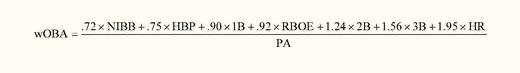

In [17]:
out_run_value = run_values.filter(pl.col("event_code") == "out_on_batted_ball")[
    "run_value"
][0]
run_values_relative = run_values.with_columns(
    (pl.col("run_value") - out_run_value).alias("run_value_above_out")
)

run_values_relative.sort("run_value_above_out", descending=True)

event_code,average_reoi,occurrences,starting_run_expectancy,run_value,run_value_above_out
str,f64,u32,f64,f64,f64
"""home_run""",2.144967,5553,0.727359,1.417608,1.666329
"""triple""",1.834278,706,0.739062,1.095216,1.343937
"""double""",1.470431,7880,0.73483,0.735601,0.984323
"""interference""",1.386139,101,0.773179,0.61296,0.861682
"""error""",1.267449,1533,0.812993,0.454456,0.703178
"""single""",1.192214,26356,0.738251,0.453963,0.702685
"""hit_by_pitch""",1.090116,2064,0.751583,0.338534,0.587255
"""passed_ball""",1.181818,220,0.890632,0.291186,0.539908
"""walk""",0.997624,14733,0.714376,0.283248,0.53197


In [18]:
walk_relative_run_value = run_values_relative.filter(pl.col("event_code") == "walk")[
    "run_value_above_out"
][0]

hbp_relative_run_value = run_values_relative.filter(
    pl.col("event_code") == "hit_by_pitch"
)["run_value_above_out"][0]

hr_relative_run_value = run_values_relative.filter(pl.col("event_code") == "home_run")[
    "run_value_above_out"
][0]
double_relative_run_value = run_values_relative.filter(
    pl.col("event_code") == "double"
)["run_value_above_out"][0]
single_relative_run_value = run_values_relative.filter(
    pl.col("event_code") == "single"
)["run_value_above_out"][0]
triple_relative_run_value = run_values_relative.filter(
    pl.col("event_code") == "triple"
)["run_value_above_out"][0]

print(f"walk_relative_run_value: {walk_relative_run_value:.2f}")
print(f"hbp_relative_run_value: {hbp_relative_run_value:.2f}")
print(f"hr_relative_run_value: {hr_relative_run_value:.2f}")
print(f"double_relative_run_value: {double_relative_run_value:.2f}")
print(f"single_relative_run_value: {single_relative_run_value:.2f}")
print(f"triple_relative_run_value: {triple_relative_run_value:.2f}")

walk_relative_run_value: 0.53
hbp_relative_run_value: 0.59
hr_relative_run_value: 1.67
double_relative_run_value: 0.98
single_relative_run_value: 0.70
triple_relative_run_value: 1.34


In [19]:
player_pa = (
    df.group_by("batter")
    .agg(
        pl.col("pa").sum().alias("plate_appearances"),
        pl.col("sf").sum().alias("total_sf"),
        pl.col("sh").sum().alias("total_sh"),
        pl.col("xi").sum().alias("total_xi"),
        pl.col("hr").sum().alias("total_homeruns"),
        (pl.col("walk").sum() + pl.col("iw").sum()).alias("total_walks"),
        pl.col("hbp").sum().alias("total_hbp"),
        pl.col("single").sum().alias("total_singles"),
        pl.col("double").sum().alias("total_doubles"),
        pl.col("triple").sum().alias("total_triples"),
    )
    .with_columns(  # Calculate proper wOBA denominator
        (
            pl.col("plate_appearances")
            - pl.col("total_sf")
            - pl.col("total_sh")
            - pl.col("total_xi")
        ).alias("woba_denominator")
    )
)
player_pa = player_pa.filter(pl.col("plate_appearances") > 502)
player_pa = player_pa.with_columns(
    (
        (
            (pl.col("total_homeruns") * hr_relative_run_value)
            + (pl.col("total_triples") * triple_relative_run_value)
            + (pl.col("total_doubles") * double_relative_run_value)
            + (pl.col("total_singles") * single_relative_run_value)
            + (pl.col("total_walks") * walk_relative_run_value)
            + (pl.col("total_hbp") * hbp_relative_run_value)
        )
        / pl.col("woba_denominator")
    ).alias("wOBA")
)
player_pa = player_pa.sort("wOBA", descending=True)
player_pa

batter,plate_appearances,total_sf,total_sh,total_xi,total_homeruns,total_walks,total_hbp,total_singles,total_doubles,total_triples,woba_denominator,wOBA
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
"""judga001""",770,4,0,1,61,165,11,89,38,1,765,0.388455
"""ohtas001""",810,5,0,4,58,105,7,108,39,7,801,0.349939
"""sotoj001""",779,5,0,0,45,148,4,99,35,4,774,0.342969
"""alvay001""",644,4,0,0,35,87,10,100,35,2,640,0.340442
"""wittb002""",737,8,0,0,32,67,8,128,45,11,729,0.3329
"""guerv002""",699,4,0,0,30,84,5,124,44,1,695,0.33007
"""martk001""",586,9,0,0,36,72,5,87,23,2,577,0.32528
"""rookb001""",614,4,0,0,39,63,5,93,26,2,610,0.319782
"""harpb003""",651,2,1,0,31,92,2,86,45,0,648,0.318669


In [20]:
df = df.join(
    player_pa.select("batter", "wOBA"),
    on="batter",
    how="left",
)

In [21]:
avg_unscaled_woba = player_pa.select(pl.col("wOBA").mean()).to_series()[0]
print(f"Average unscaled wOBA: {avg_unscaled_woba:.3f}")

Average unscaled wOBA: 0.268


Note that this unscaled wOBA value is not on the same scale as traditional wOBA. Traditional wOBA is scaled to be on the same scale as batting average, which is done by dividing by a constant. We will not be doing this scaling, as we are more interested in the relative values of players rather than their absolute values.

### Base/Out State Run Expectancy with distributions

In [ ]:
run_expectancy_with_distributions = df.group_by("n_bases_pre", "outs_pre").agg(
    pl.col("runs_scored_from_here").mean().alias("run_expectancy"),
    pl.col("runs_scored_from_here").count().alias("occurrences"),
    (
        (
            (pl.col("runs_scored_from_here") == 0).sum()
            / pl.col("runs_scored_from_here").count()
        )
        * 100
    ).alias("pct_no_run_scored"),
    (
        (pl.col("runs_scored_from_here") == 1).sum()
        / pl.col("runs_scored_from_here").count()
        * 100
    ).alias("pct_one_run_scored"),
    (
        (pl.col("runs_scored_from_here") == 2).sum()
        / pl.col("runs_scored_from_here").count()
        * 100
    ).alias("pct_two_runs_scored"),
    (
        (pl.col("runs_scored_from_here") == 3).sum()
        / pl.col("runs_scored_from_here").count()
        * 100
    ).alias("pct_three_runs_scored"),
    (
        (pl.col("runs_scored_from_here") == 4).sum()
        / pl.col("runs_scored_from_here").count()
        * 100
    ).alias("pct_four_runs_scored"),
    (
        (
            (pl.col("runs_scored_from_here") >= 5).sum()
            / pl.col("runs_scored_from_here").count()
        )
        * 100
    ).alias("pct_five_or_more_runs_scored"),
)

run_expectancy_with_distributions = run_expectancy_with_distributions.sort(
    "n_bases_pre", "outs_pre"
)
run_expectancy_with_distributions

n_bases_pre,outs_pre,run_expectancy,occurrences,pct_no_run_scored,pct_one_run_scored,pct_two_runs_scored,pct_three_runs_scored,pct_four_runs_scored,pct_five_or_more_runs_scored
str,i64,f64,u32,f64,f64,f64,f64,f64,f64
"""0/0/0""",0,0.719405,53800,64.057621,17.434944,9.234201,4.817844,2.334572,2.120818
"""0/0/0""",1,0.498098,39958,73.444617,14.064768,6.591922,3.198358,1.446519,1.253817
"""0/0/0""",2,0.348162,31988,80.789671,10.538327,4.792422,2.10704,1.016006,0.756534
"""0/0/1""",0,1.639004,482,17.634855,44.605809,16.804979,8.713693,6.639004,5.60166
"""0/0/1""",1,1.218373,1992,30.220884,42.269076,14.457831,6.526104,3.76506,2.761044
"""0/0/1""",2,0.582161,3128,65.537084,20.396419,8.280051,3.388747,1.278772,1.118926
"""0/1/0""",0,1.360895,4112,33.58463,32.56323,16.439689,8.633268,4.109922,4.669261
"""0/1/0""",1,0.925968,6092,52.248851,24.507551,11.736704,5.925804,2.90545,2.67564
"""0/1/0""",2,0.59226,8010,67.315855,18.127341,7.940075,3.558052,1.635456,1.423221


In [23]:
df = df.rename({"wOBA": "batter_wOBA"})

In [ ]:
df.head()

# Chapter 2 - When you're hot you're hot